In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from torch.utils.data.dataloader import default_collate

from datasets.syn_signs_loader import syn_signs
from models.gtsrb_cnn import GTSRB_CNN

device = torch.device("cpu")
batch_size = 64
pin_memory = False

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    pin_memory = True

### Load Datasets

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((48, 48)),
                    # transforms.Normalize((0.5,), (0.5,)),
            ])

target_trainset = datasets.GTSRB(root = "./data", split = "train", download = True, transform = transform)
target_testset = datasets.GTSRB(root = "./data", split = "test", download = True, transform = transform)

In [3]:
# obtain training indices that will be used for validation
val_size = 0.2
num_train = len(target_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
# split = 1280
train_index, val_index = indices[split:], indices[:split] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

target_trainloader = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler, pin_memory = pin_memory)
target_valloader = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler, pin_memory = pin_memory)
target_testloader = torch.utils.data.DataLoader(target_testset, batch_size = batch_size
                                                    , shuffle = True, num_workers = 2, pin_memory = pin_memory)

print("Target Train set size = %d, Val set size = %d, Test set size = %d" % (len(target_trainloader), 
                                                                      len(target_valloader), len(target_testloader)))

Target Train set size = 333, Val set size = 84, Test set size = 198


In [4]:
source_trainset = syn_signs(root = "./data/syn_signs/Images", transform = transform)

In [5]:
# obtain training indices that will be used for validation
val_size = 0.2
num_train = len(source_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
split = num_train - 100000
train_index, val_index = indices[split:], indices[:split] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

source_trainloader = torch.utils.data.DataLoader(source_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler, pin_memory = pin_memory)
source_valloader = torch.utils.data.DataLoader(source_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler, pin_memory = pin_memory)

print("Source Train set size = %d, Val set size = %d" % (len(source_trainloader), len(source_valloader)))

Source Train set size = 1563, Val set size = 353


### Visualize

In [6]:
def extract_feats(model, loader):
    model = model.to(device)
    all_feats = []
    
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        feats = model.feature(data).cpu().detach().numpy()
        all_feats.append(feats)

    all_feats = np.vstack(np.array(all_feats))
    return all_feats

In [7]:
def visualize2D(source_feats, target_feats):
    # Create a two dimensional t-SNE projection of the embeddings
    tsne = TSNE(2, verbose = 1)
    tsne_proj_source = tsne.fit_transform(source_feats)
    tsne_proj_target = tsne.fit_transform(target_feats)
    
    # Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap("tab20")
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.scatter(tsne_proj_source[:, 0], tsne_proj_source[:, 1], 
               c = np.array(cmap(0)), label = "Source", alpha = 0.5)
    
    ax.scatter(tsne_proj_target[:, 0], tsne_proj_target[:, 1], 
               c = np.array(cmap(10)), label = "Target", alpha = 0.5)

    ax.legend(fontsize = "large", markerscale = 2)
    plt.show()

In [8]:
def visualize3D(source_feats, target_feats):
    # Create a two dimensional t-SNE projection of the embeddings
    tsne = TSNE(3, verbose = 1)
    tsne_proj_source = tsne.fit_transform(source_feats)
    tsne_proj_target = tsne.fit_transform(target_feats)
    
    # Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap("tab20")
    # fig, ax = plt.subplots(figsize=(8, 8))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = "3d")
    
    ax.scatter(tsne_proj_source[:, 0], tsne_proj_source[:, 1], tsne_proj_source[:, 2],
               c = np.array(cmap(0)), label = "Source", alpha = 0.5)
    
    ax.scatter(tsne_proj_target[:, 0], tsne_proj_target[:, 1], tsne_proj_target[:, 2],
               c = np.array(cmap(10)), label = "Target", alpha = 0.5)

    ax.legend(fontsize = "large", markerscale = 2)
    plt.show()

### GRL Model

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.640s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 4.385023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.381184
[t-SNE] KL divergence after 1000 iterations: 0.442902
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.182s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 1.071030


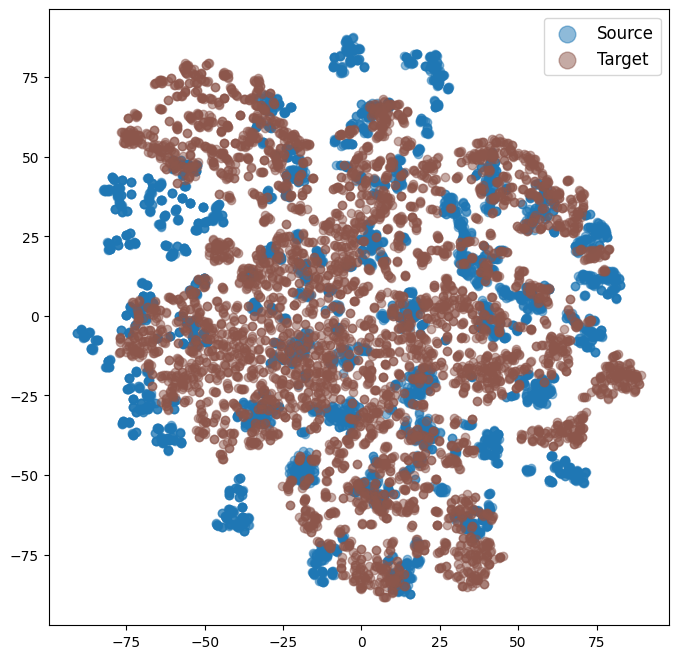

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 1.200s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 4.385023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.708366
[t-SNE] KL divergence after 1000 iterations: 0.370360
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.173s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 0.902806


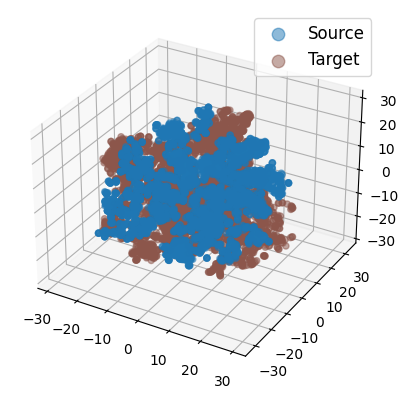

In [9]:
grl_model = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt"
grl_model.load_state_dict(torch.load(model_save_path))
grl_model.eval()

source_feats = extract_feats(grl_model, source_valloader)[:5000, :]
target_feats = extract_feats(grl_model, target_valloader)[:5000, :]
visualize2D(source_feats, target_feats)
visualize3D(source_feats, target_feats)

### Mean Loss with GRL Model

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 2.210s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.310148
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.437202
[t-SNE] KL divergence after 1000 iterations: 0.283709
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.197s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 1.061381


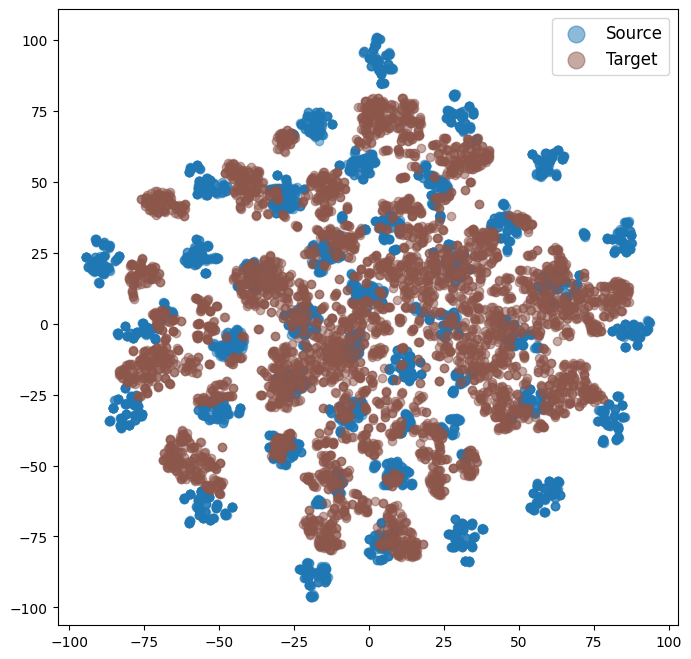

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.189s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.310148
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.246017
[t-SNE] KL divergence after 1000 iterations: 0.225699
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.210s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 0.878215


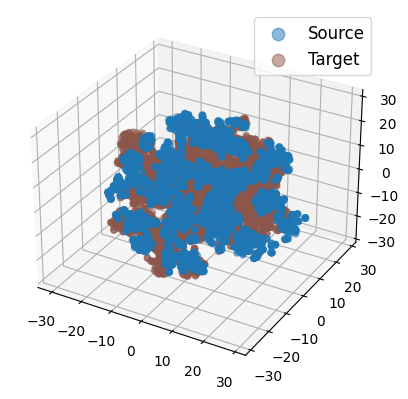

In [10]:
mean_model = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_mean_loss.pt"
mean_model.load_state_dict(torch.load(model_save_path))
mean_model.eval()

source_feats = extract_feats(mean_model, source_valloader)[:5000, :]
target_feats = extract_feats(mean_model, target_valloader)[:5000, :]
visualize2D(source_feats, target_feats)
visualize3D(source_feats, target_feats)

### Source Only Model

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.012s...
[t-SNE] Computed neighbors for 5000 samples in 1.273s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 14.368289
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.438290
[t-SNE] KL divergence after 1000 iterations: 0.390227
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 1.229s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 1.125058


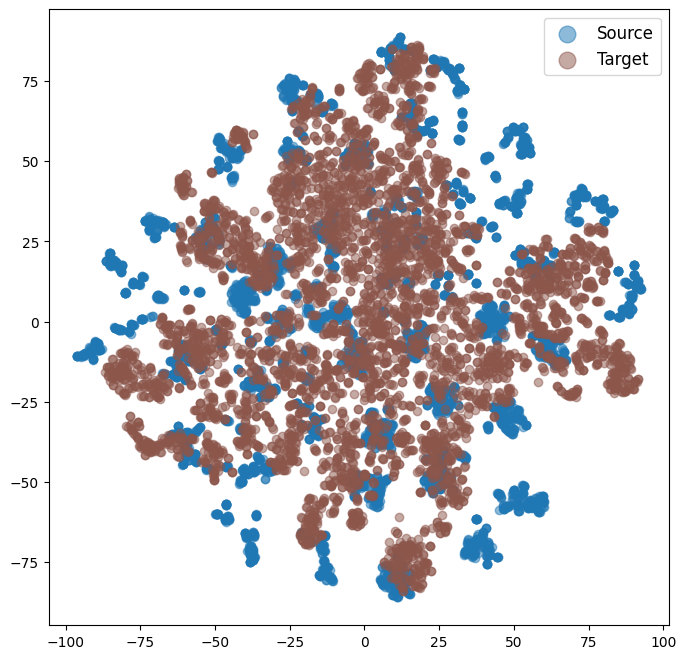

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 1.229s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 14.368289
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.633877
[t-SNE] KL divergence after 1000 iterations: 0.319176
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 1.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 0.926548


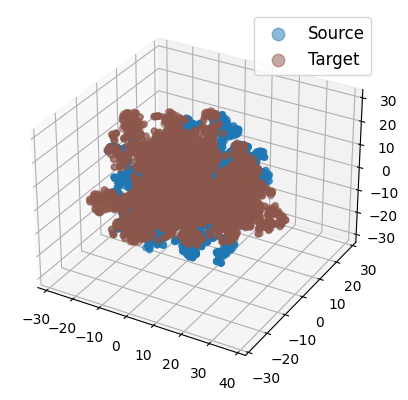

In [32]:
source_only_model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_source_only.pt"
source_only_model.load_state_dict(torch.load(model_save_path))
source_only_model.eval()

source_feats = extract_feats(source_only_model, source_valloader)[:5000, :]
target_feats = extract_feats(source_only_model, target_valloader)[:5000, :]
visualize2D(source_feats, target_feats)
visualize3D(source_feats, target_feats)

### Target Only Model

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.243s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 17.934335
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.180664
[t-SNE] KL divergence after 1000 iterations: 0.550587
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.218s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 0.871736


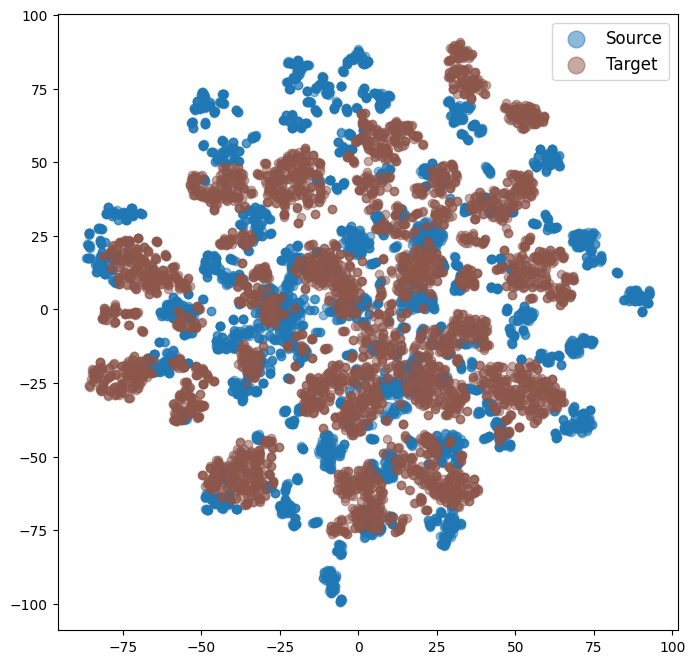

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.251s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 17.934335
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.920624
[t-SNE] KL divergence after 1000 iterations: 0.453123
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 0.706074


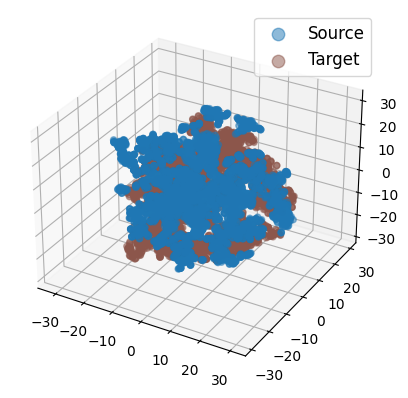

In [33]:
target_only_model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_target_only.pt"
target_only_model.load_state_dict(torch.load(model_save_path))
target_only_model.eval()

source_feats = extract_feats(target_only_model, source_valloader)[:5000, :]
target_feats = extract_feats(target_only_model, target_valloader)[:5000, :]
visualize2D(source_feats, target_feats)
visualize3D(source_feats, target_feats)